In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import soundfile as sf
import os
import numpy as np
import scipy as sp
import random
import webrtcvad
import collections
import contextlib
import struct
import audiolazy
import scipy.signal

In [4]:
spoof_audio_dir = '/nas/home/cborrelli/bot_speech/notebook/audio/spoof'
bonafide_audio_dir = '/nas/home/cborrelli/bot_speech/notebook/audio/bonafide'

spoof_audio_files = [o for o in os.listdir(spoof_audio_dir) if o.endswith('.flac')]
bonafide_audio_files = [o for o in os.listdir(bonafide_audio_dir) if o.endswith('.flac')]

In [5]:
def float2pcm(sig, dtype='int16'):
    sig = np.asarray(sig)
    if sig.dtype.kind != 'f':
        raise TypeError("'sig' must be a float array")
    dtype = np.dtype(dtype)
    if dtype.kind not in 'iu':
        raise TypeError("'dtype' must be an integer type")

    i = np.iinfo(dtype)
    abs_max = 2 ** (i.bits - 1)
    offset = i.min + abs_max
    return (sig * abs_max + offset).clip(i.min, i.max).astype(dtype)

In [6]:
def run_vad(data):
    vad = webrtcvad.Vad()
    vad.set_mode(3)
    audio = float2pcm(data)
    raw_samples = struct.pack("%dh" % len(audio), *audio)
    window_duration = 0.03 # duration in seconds
    samples_per_window = int(window_duration * samplerate)
    number_windows = int(np.floor(len(audio) / samples_per_window))
    bytes_per_sample = 2

    segments = []
    for i in np.arange(number_windows):
        raw_frame = raw_samples[i * bytes_per_sample * samples_per_window: 
                                (i+1) * bytes_per_sample * samples_per_window]
        is_speech = vad.is_speech(raw_frame, sample_rate=samplerate)
        segments.append(dict(
           start = i * samples_per_window,
           stop = (i+1) * samples_per_window-1,
           is_speech = is_speech))
        
    old_bool = segments[0]['is_speech']
    new_start = segments[0]['start']
    
    long_segments = []
    for i, segment in enumerate(segments):
        new_bool = segment['is_speech']
        if old_bool == new_bool:
            new_stop = segment['stop']     
        else:
            long_segments.append(dict(
               start = new_start,
               stop = new_stop,
               is_speech = old_bool))
            new_start = segment['start']
            new_stop = segment['stop']
        old_bool = new_bool
        if i == len(segments) - 1:
            long_segments.append(dict(
               start = new_start,
               stop = new_stop,
               is_speech = old_bool))
    return long_segments

In [7]:
len_lpc = np.arange(20, 60, 2)


### Bonafide audio analysis

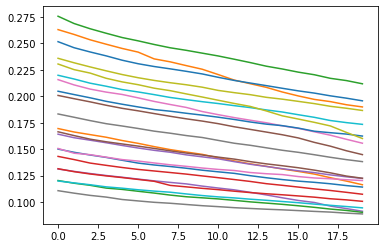

In [8]:
res_mse = []
gain_track_bonafide = []
for t in bonafide_audio_files[:20]:
    data, samplerate = sf.read(os.path.join(bonafide_audio_dir, t))
    ipd.Audio(data, rate=samplerate)

    segments = run_vad(data)
    
    ymax = max(data)
    # plot segment identifed as speech
    for ii, segment in enumerate(segments):
        if segment['is_speech']:
            if segment['stop'] - segment['start'] <= int(0.2*samplerate):
                break
            voice = np.asarray(data[segment['start']:segment['stop']])
            
            window_length = int(0.025*samplerate)
            win_number = int(np.floor(len(voice) / window_length))
            res_energy = []
            y_hat = []
            coeff = []
            res = []
            frames = []
            gain_track = []
            for i in np.arange(win_number):
                frame = voice[i*window_length:(i+1)*window_length]
                coeff_frame = []
                y_hat_frame = []
                res_frame = []
                gain_frame = []
                max_frame = []
                min_frame = []
                #plt.figure(figsize=(16,8))
                for l in len_lpc:
                    a = librosa.lpc(frame, int(l))
                    y_hat_frame.append(sp.signal.lfilter([0]+ -1*a[1:], [1], frame))
                    coeff_frame.append(a)
                    res = np.asarray(sp.signal.lfilter(a, [1], frame))
                    res[:l+1] = np.nan
                    res[-l-1:] = np.nan
                    res_frame.append(res)
                    #plt.plot(res_frame[-1])
                    
                    w, h = scipy.signal.freqz([1], a, worN=256)
                    gain = np.sqrt(np.nansum(res_frame[-1]**2))
                    gain_frame += [gain]
                    max_frame += [np.max(res_frame[-1][np.where(np.isnan(res_frame[-1])!=True)])]
                    min_frame += [np.min(res_frame[-1][np.where(np.isnan(res_frame[-1])!=True)])]
                    #plt.plot(w, np.abs(h)*gain)
                frame_fft = np.abs(np.fft.fft(frame, 512))[:256]
                #plt.plot(w, frame_fft)
                
                gain_track += [gain_frame]
                '''
                plt.figure(figsize=(16,8))
                plt.subplot(121)
                plt.plot(res_frame[-1])
                plt.subplot(122)
                plt.plot(gain_frame)
                plt.plot(max_frame)
                plt.plot(min_frame)
                plt.show()
                '''
            #plt.figure(figsize=(10,5))
            plt.plot(np.asarray(gain_track).mean(axis=0))
            gain_track_bonafide += [np.asarray(gain_track).mean(axis=0)]
plt.show()
gain_track_bonafide = np.asarray(gain_track_bonafide).T

### Predicted vs real signal on a window for different orders

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(frames[8,:])
plt.plot(y_hat[8,0,:], color='red')

plt.figure(figsize=(16,8))
plt.plot(frames[8,:])
plt.plot(y_hat[8,3,:], color='green')


### Residual ad different orders on a window

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(res[20,0,:], color='red')
plt.plot(res[20,3,:])


In [ ]:
#print([np.sum(np.power(res[j,i,:], 2)) for j in np.arange(frames.shape[0])])
frames.shape

### Residual energy short time

In [ ]:
# Short time residual
plt.figure(figsize=(16 ,8))
plt.xlabel('Window index')
plt.ylabel('Residual energy')
for i in np.arange(len(len_lpc)):
    #plt.plot([np.sum(np.power(res[j,i,:], 2)) for j in np.arange(frames.shape[0])], marker='*')
    plt.plot([np.sum(np.power(res[j,i,:], 2)) for j in np.arange(10)], marker='*')
plt.legend(len_lpc)

plt.figure(figsize=(16, 8))
plt.xlabel('Window index')
plt.ylabel('Original signal')
plt.plot(frames.flatten())
plt.show()

### Global residual energy

In [ ]:
plt.figure(figsize=(16,8))
plt.xlabel('LPC length')
plt.xticks(np.arange(len(len_lpc)), len_lpc)
plt.ylabel('Residual energy')
plt.plot([np.sum(np.power(res[:,i,:], 2)) for i in np.arange(len(len_lpc))], marker='*')

In [ ]:
np.sum(np.abs(res[1,0,:]))

### Same for spoof

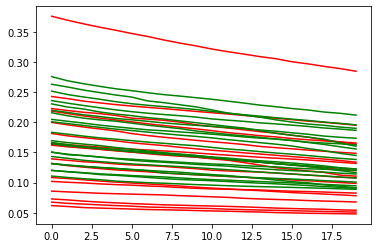

In [151]:
spoof_res_mse = []
for t in spoof_audio_files[:20]:
    data, samplerate = sf.read(os.path.join(spoof_audio_dir, t))
    ipd.Audio(data, rate=samplerate)

    segments = run_vad(data)
    
    ymax = max(data)
    # plot segment identifed as speech
    for ii, segment in enumerate(segments):
        if segment['is_speech']:
            if segment['stop'] - segment['start'] <= int(1*samplerate):
                break
            voice = np.asarray(data[segment['start']:segment['stop']])
            
            window_length = int(0.025*samplerate)
            win_number = int(np.floor(len(voice) / window_length))
            y_hat = []
            coeff = []
            res = []
            frames = []
            gain_track = []
            for i in np.arange(win_number):
                frame = voice[i*window_length:(i+1)*window_length]
                #plt.plot(frame)
                coeff_frame = []
                y_hat_frame = []
                res_frame = []
                gain_frame = []
                max_frame = []
                min_frame = []
                #plt.figure(figsize=(15, 3))
                for l_idx, l in enumerate(len_lpc):
                    a = librosa.lpc(frame, int(l))
                    y_hat_frame.append(sp.signal.lfilter([0]+ -1*a[1:], [1], frame))
                    coeff_frame.append(a)
                    res = np.asarray(sp.signal.lfilter(a, [1], frame))
                    res[:l+1] = np.nan
                    res[-l-1:] = np.nan
                    res_frame.append(res)
                    #plt.plot(res_frame[-1])
                    
                    w, h = scipy.signal.freqz([1], a, worN=256)
                    gain = np.sqrt(np.nansum(res_frame[-1]**2))

                    #gain = np.std(res_frame[-1])
                    gain_frame += [gain]
                    max_frame += [np.max(res_frame[-1][np.where(np.isnan(res_frame[-1])!=True)])]
                    min_frame += [np.min(res_frame[-1][np.where(np.isnan(res_frame[-1])!=True)])]
                    #plt.plot(w, np.abs(h)*gain)
                    
                gain_track += [gain_frame]
                '''
                plt.figure(figsize=(16,8))
                plt.subplot(121)
                plt.plot(res_frame[-1])
                plt.subplot(122)
                plt.plot(gain_frame)
                plt.plot(max_frame)
                plt.plot(min_frame)
                
                frame_fft = np.abs(np.fft.fft(frame, 512))[:256]
                #plt.plot(w, frame_fft)
                plt.show()
                '''
            
            
            #plt.plot(np.asarray(gain_track).mean(axis=0) / np.asarray(gain_track).mean(axis=0).max(), 'r')
            plt.plot(np.asarray(gain_track).mean(axis=0), 'r')
            
#plt.plot(gain_track_bonafide / gain_track_bonafide.max(axis=0), 'g')
plt.plot(gain_track_bonafide, 'g')
plt.show()

In [94]:
len(voice)/samplerate

1.4999375

In [ ]:
plt.figure()
plt.plot(np.asarray(res_mse)[:, 3])
#plt.ylim([0, 100])

#plt.figure()
plt.plot(np.asarray(spoof_res_mse)[:, 3])
#plt.ylim([0, 100])
plt.show()

In [ ]:
plt.hist(np.asarray(res_mse)[:, 3].ravel(), 10)
plt.hist(np.asarray(spoof_res_mse)[:, 3].ravel(), 10)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
x_0 = np.asarray(spoof_res_mse)[:, 3]
x_1 = np.asarray(res_mse)[:, 3]
x = np.concatenate([x_0, x_1])

y = np.concatenate([np.zeros_like(x_0), np.ones_like(x_1)])
[fpr, tpr, th] = roc_curve(y, x)
roc_auc = roc_auc_score(y, x)

plt.plot(fpr, tpr, label='AUC={}'.format(roc_auc))
plt.plot([0, 1], [0, 1], ':k')
plt.legend()
plt.show()

acc = (tpr + (1-fpr)) / 2
best_th = th[np.where(acc == np.max(acc))]
print(best_th)
print(acc.max())

In [ ]:
res_mse

In [ ]:
# Short time residual
plt.figure(figsize=(16 ,8))
plt.xlabel('Window index')
plt.ylabel('Residual energy')
for i in np.arange(len(len_lpc)):
    plt.plot([np.sum(np.power(spoof_res[j,i,:], 2)) for j in np.arange(spoof_frames.shape[0]//2)], marker='*')
plt.legend(len_lpc)


plt.figure(figsize=(16, 8))
plt.xlabel('Window index')
plt.ylabel('Original signal')
plt.plot(spoof_frames.flatten()[:200])
plt.show()

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(res[0,0,800:1000], color='red')
plt.plot(res[0,3,800:1000])

In [ ]:
plt.figure(figsize=(16,8))
plt.xlabel('LPC length')
plt.xticks(np.arange(len(len_lpc)), len_lpc)
plt.ylabel('Residual energy')
plt.plot([np.sum(np.power(res[0,i,:], 2)) for i in np.arange(len(len_lpc))], marker='*')

In [ ]:

import librosa
import librosa.display
plt.figure(figsize=(16, 8))
S_dB = librosa.power_to_db(librosa.feature.melspectrogram(y=frames.flatten(), sr=samplerate), ref=np.max)
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=samplerate, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.show()

In [ ]:
for i in np.arange(len(len_lpc)):
    plt.figure(figsize=(16, 8))
    S_dB = librosa.power_to_db(librosa.feature.melspectrogram(y=y_hat[:,i,:].flatten(), sr=samplerate), ref=np.max)
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=samplerate, fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.show()

In [ ]:
import IPython.display as ipd
ipd.Audio(data, rate=samplerate)

In [ ]:
res_mse = []
for t in bonafide_audio_files[:1]:
    data, samplerate = sf.read(os.path.join(bonafide_audio_dir, t))
    ipd.Audio(data, rate=samplerate)

    segments = run_vad(data)
    
    ymax = max(data)
    # plot segment identifed as speech
    for ii, segment in enumerate(segments):
        if segment['is_speech']:
            if segment['stop'] - segment['start'] <= int(0.2*samplerate):
                break
            voice = np.asarray(data[segment['start']:segment['stop']])
            
            window_length = int(0.025*samplerate)
            win_number = int(np.floor(len(voice) / window_length))
            res_energy = []
            y_hat = []
            coeff = []
            res = []
            frames = []
            for i in np.arange(10): #np.arange(win_number):
                frame = voice[i*window_length:(i+1)*window_length]
                coeff_frame = []
                y_hat_frame = []
                res_frame = []
                
                plt.figure(figsize=(15, 3))
                for l_idx, l in enumerate(len_lpc):
                    a = librosa.lpc(frame, l)
                    y_hat_frame.append(sp.signal.lfilter([0]+ -1*a[1:], [1], frame))
                    coeff_frame.append(a)
                    res_frame.append(np.asarray(sp.signal.lfilter([1], [0]+ -1*a[1:], frame)))
                    
                    
                    
                    plt.subplot(1,4,l_idx+1)
                    plt.plot(res_frame[-1])
                plt.show()
                    
                    
                y_hat.append(y_hat_frame)
                res.append(res_frame)
                coeff.append(coeff_frame)
                frames.append(frame)
            
            y_hat = np.asarray(y_hat)
            res = np.asarray(res)
            frames = np.asarray(frames)
            
            res_mse.append(np.mean(res**2, axis=(0, 2)))
            break
            #plt.figure(figsize=(16,8))
            #plt.plot(len_lpc, res_energy)
            #plt.grid()
            #plt.title('Audio file: '+ t + ', fragment: '+ str(ii))


In [ ]:
0.025*16000

In [73]:
win_number

15

### Try LPC

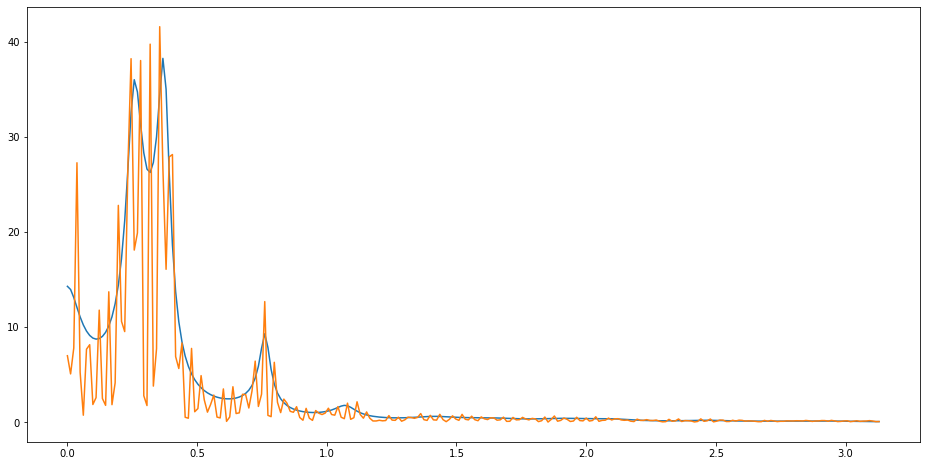

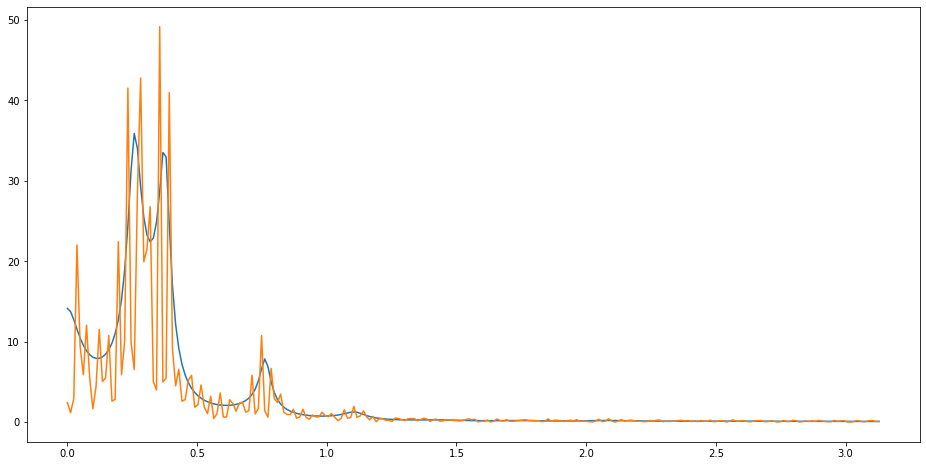

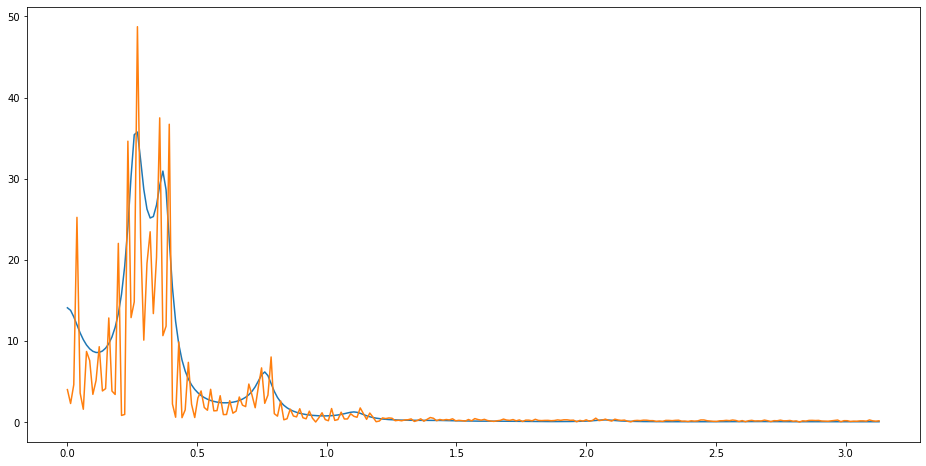

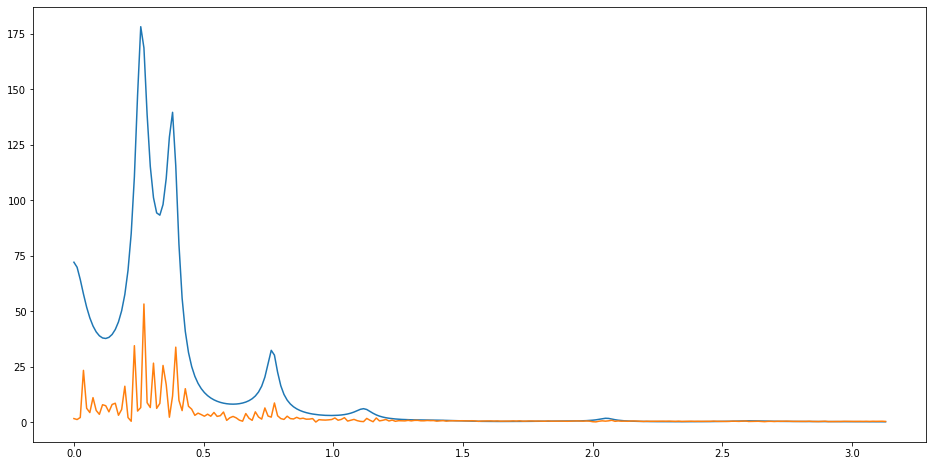

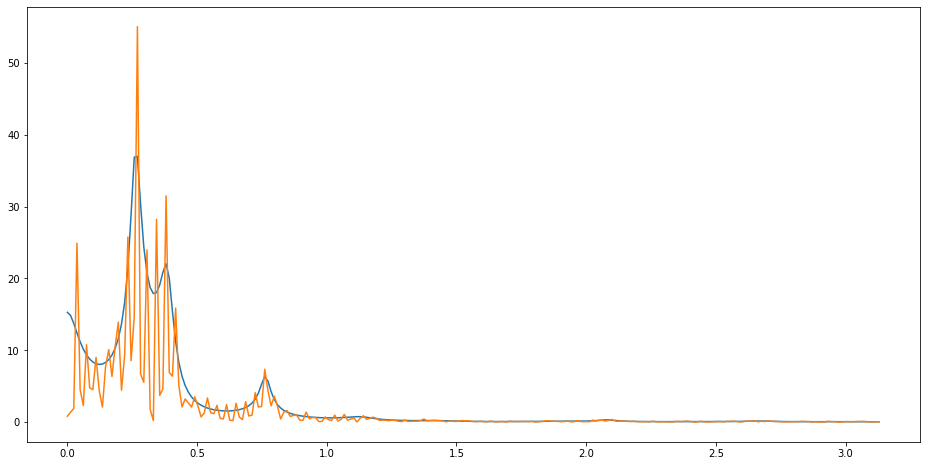

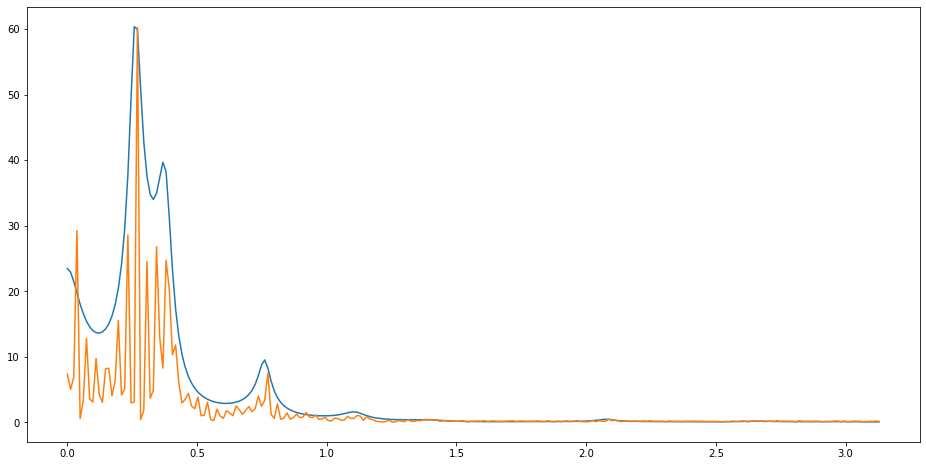

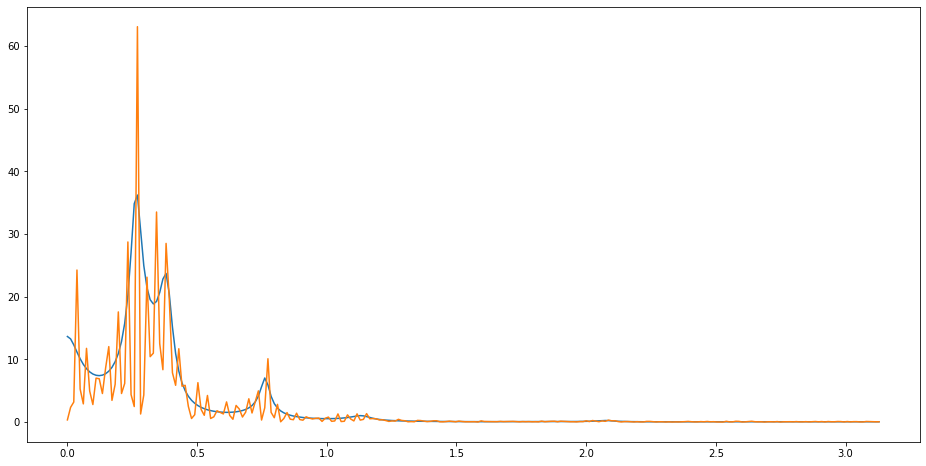

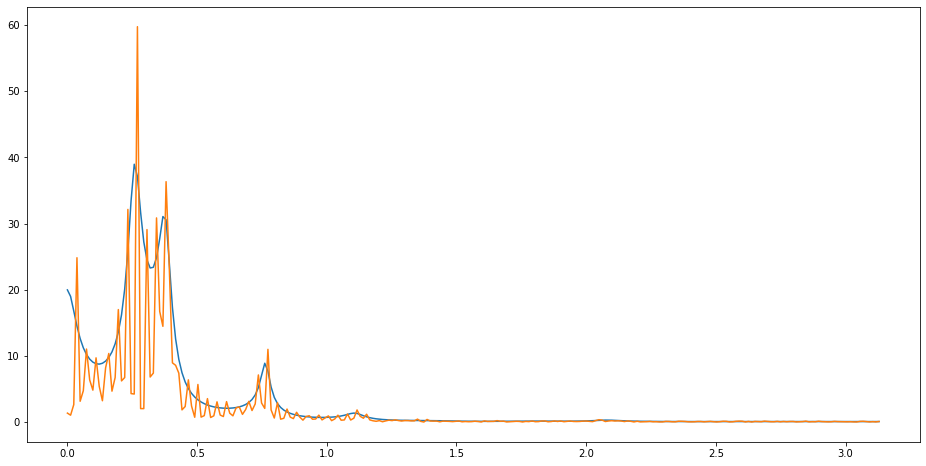

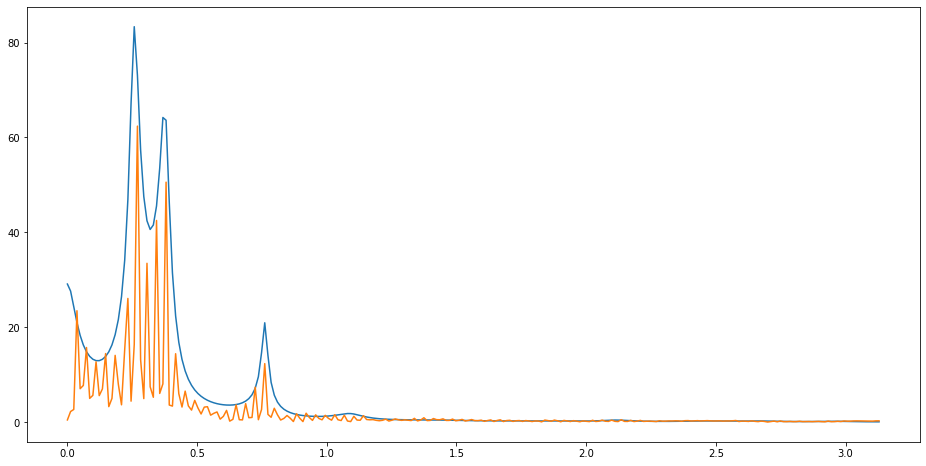

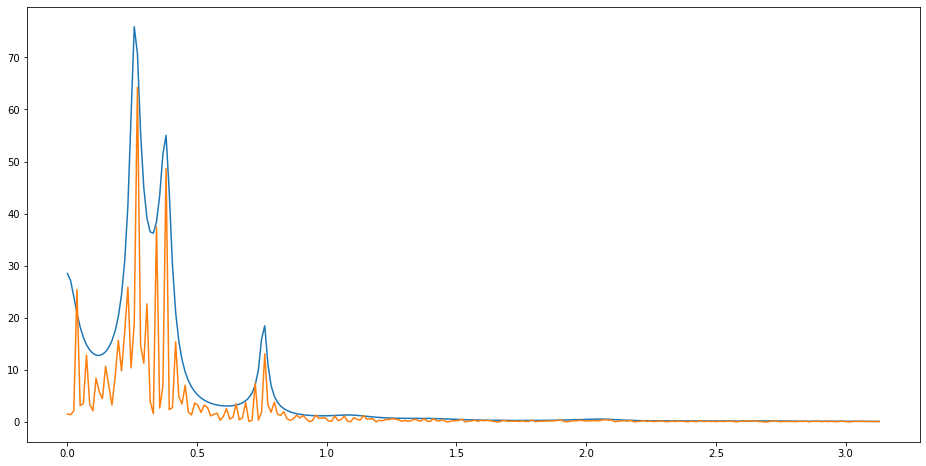

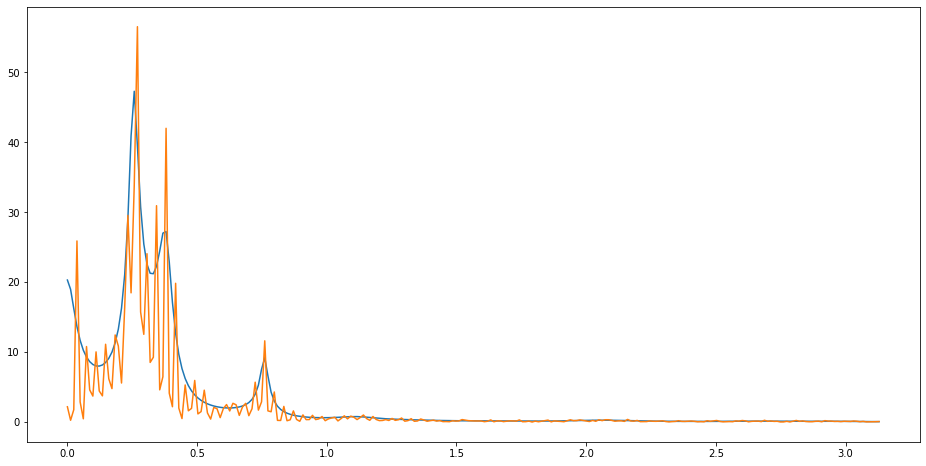

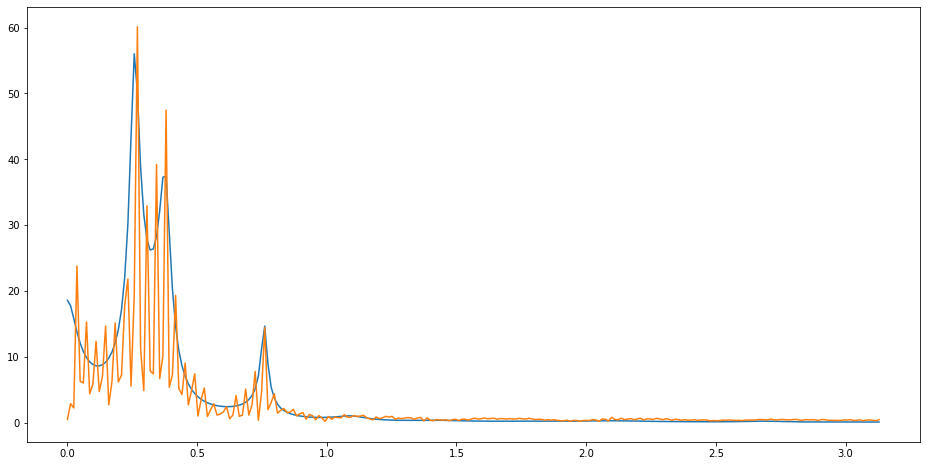

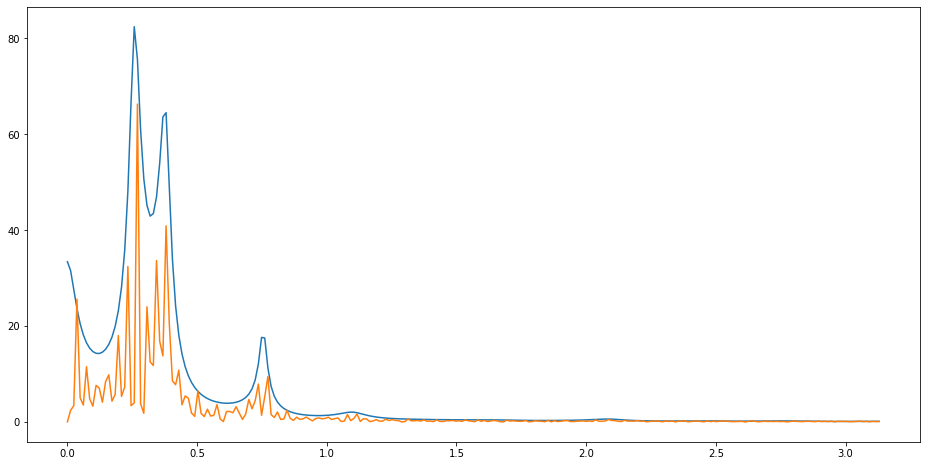

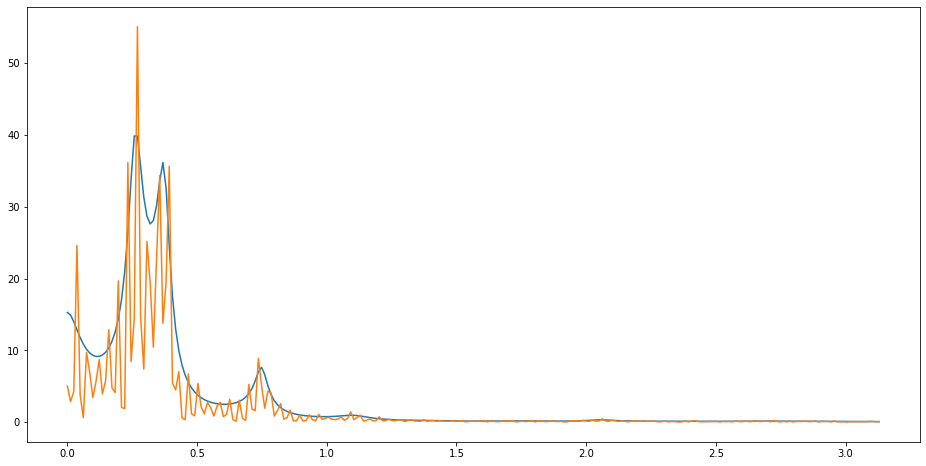

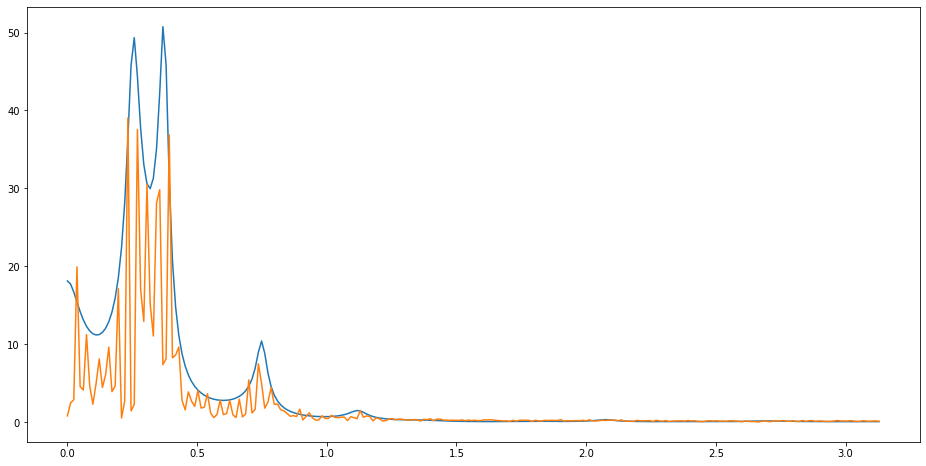

In [76]:
lpc_lengths = [25]
voice, samplerate = sf.read(os.path.join('audio', 'voiced_a.wav'))
window_length = int(0.025*samplerate)
win_number = int(np.floor(len(voice) / window_length))
for i in np.arange(win_number): #np.arange(win_number):
    frame = voice[i*window_length:(i+1)*window_length]
    plt.figure(figsize=(16,8))

    for l in lpc_lengths:
        a = librosa.lpc(frame, l)

        res = sp.signal.lfilter(a, [1], frame)
        #plt.plot(res)
        
        w, h = scipy.signal.freqz([1], a, worN=256)
        #plt.figure()
        gain = np.sqrt(np.sum(res**2))
        plt.plot(w, np.abs(h)*gain)
    #plt.legend(len_lpc)
    frame_fft = np.abs(np.fft.fft(frame, 512)[:256])
    plt.plot(w, frame_fft)
    #plt.ylim([0, 5])
    plt.show()
